In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import prophet
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("Final.csv")

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df['temp']=df['max_temp']-df['min_temp']

In [5]:
df.drop(['max_temp','min_temp'],axis=1,inplace=True)

In [6]:
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

df["PM2.5_SubIndex"] = df["PM2.5"].apply(lambda x: get_PM25_subindex(x))

def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

df["PM10_SubIndex"] = df["PM10"].apply(lambda x: get_PM10_subindex(x))


def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

df["SO2_SubIndex"] = df["SO2"].apply(lambda x: get_SO2_subindex(x))

def get_NOx_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

df["NOx_SubIndex"] = df["NO2"].apply(lambda x: get_NOx_subindex(x))

def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

df["CO_SubIndex"] = df["CO"].apply(lambda x: get_CO_subindex(x))


def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

df["O3_SubIndex"] = df["Ozone"].apply(lambda x: get_O3_subindex(x))

In [7]:
df1=df.copy()

In [8]:
df1.drop(['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Ozone'],axis=1,inplace=True)

In [9]:
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

df1["Checks"] = (df1["PM2.5_SubIndex"] > 0).astype(int) + \
                (df1["PM10_SubIndex"] > 0).astype(int) + \
                (df1["SO2_SubIndex"] > 0).astype(int) + \
                (df1["NOx_SubIndex"] > 0).astype(int) + \
                (df1["CO_SubIndex"] > 0).astype(int) + \
                (df1["O3_SubIndex"] > 0).astype(int)

df1["AQI_calculated"] = round(df1[["PM2.5_SubIndex", "PM10_SubIndex", "SO2_SubIndex", "NOx_SubIndex",
                                  "CO_SubIndex", "O3_SubIndex"]].max(axis = 1))
df1.loc[df["PM2.5_SubIndex"] + df1["PM10_SubIndex"] <= 0, "AQI_calculated"] = np.NaN
df1.loc[df1.Checks < 3, "AQI_calculated"] = np.NaN

df1["AQI_bucket_calculated"] = df1["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))

In [10]:
df1.drop(1808,axis=0,inplace=True)
df.drop(1808,axis=0,inplace=True)

In [11]:
df['AQI']=df1['AQI_calculated']

In [12]:
Df=pd.read_csv("WeatherAndAQIData.csv")

In [13]:
Df=Df[['Date','AQI','PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Ozone','relativehumidity_2m (%)', 'dewpoint_2m (°C)', 'rain (mm)',
       'windspeed_100m (km/h)', 'winddirection_100m (°)', 'temp']]

In [14]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-22', 'lower_window': 0, 'ds_upper': '2020-05-31'},
    {'holiday': 'lockdown_2', 'ds': '2021-05-12', 'lower_window': 0, 'ds_upper': '2021-05-22'}])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days


In [15]:
m=prophet.Prophet(growth='logistic',holidays=lockdowns)

In [16]:
m.add_country_holidays(country_name='IN')

In [17]:
for i in ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Ozone','relativehumidity_2m (%)', 'dewpoint_2m (°C)', 'rain (mm)',
       'windspeed_100m (km/h)', 'winddirection_100m (°)', 'temp']:
    m.add_regressor(i)

In [18]:
Df['ds']=Df['Date']
Df['y']=Df['AQI']
cap=Df['AQI'].max()
Df['cap']=cap
Df.drop(["Date","AQI"],axis=1,inplace=True)

In [ ]:
m.fit(Df)

In [ ]:
future = m.make_future_dataframe(periods=365)
today=[60,125,48,24.789,1.2,80,40.66,4.33,0.2,11,72,95,11]
j=0
for i in ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Ozone','relativehumidity_2m (%)', 'dewpoint_2m (°C)', 'rain (mm)',
       'windspeed_100m (km/h)', 'winddirection_100m (°)', 'temp']:
    future[i]=today[j]
    j+=1
future['cap']=cap
forecast=m.predict(future)

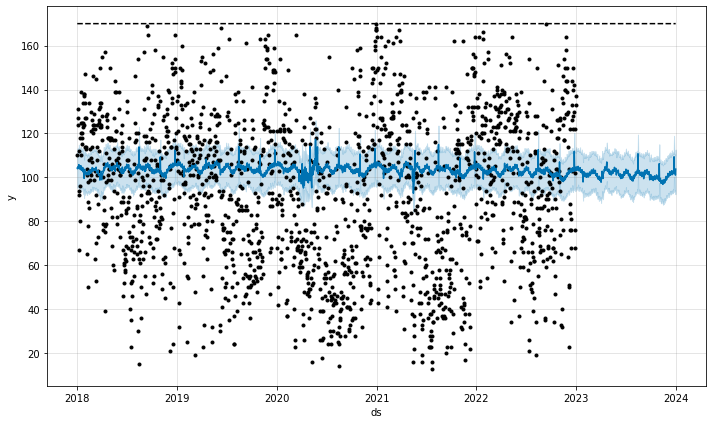

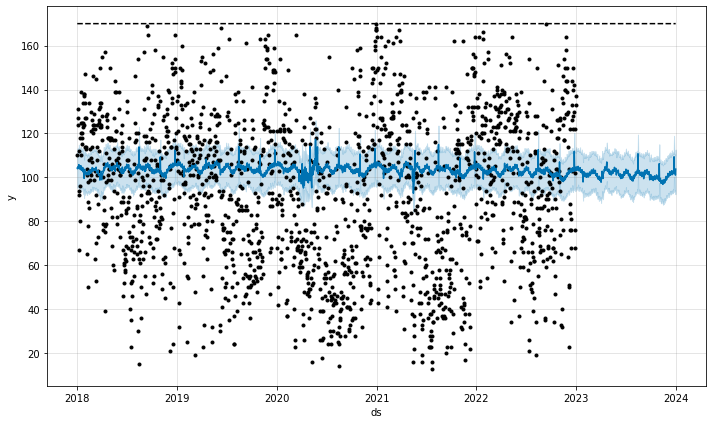

In [21]:
m.plot(forecast)

In [22]:
forecast.columns

Index(['ds', 'trend', 'cap', 'yhat_lower', 'yhat_upper', 'trend_lower',
       'trend_upper', 'All Saints Day', 'All Saints Day_lower',
       'All Saints Day_upper',
       ...
       'windspeed_100m (km/h)', 'windspeed_100m (km/h)_lower',
       'windspeed_100m (km/h)_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object', length=134)

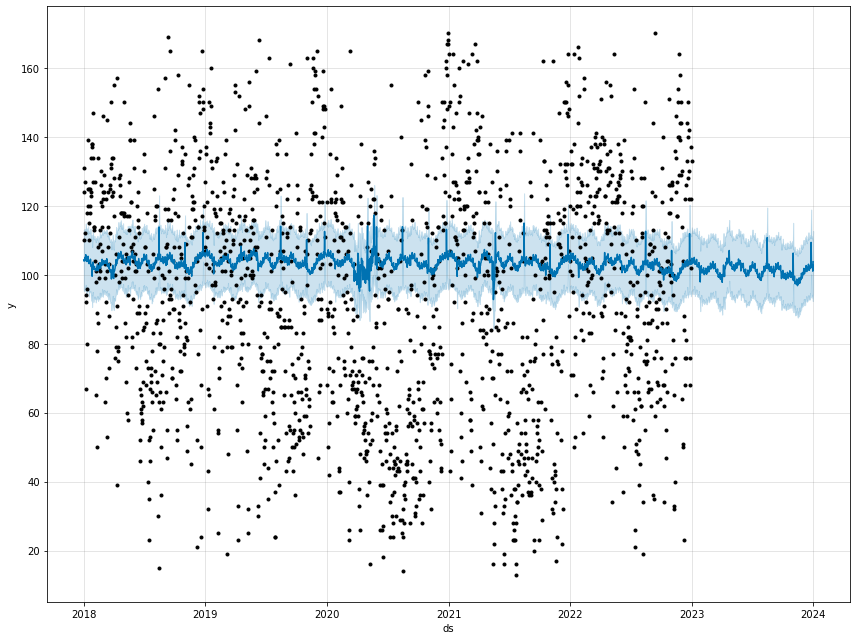

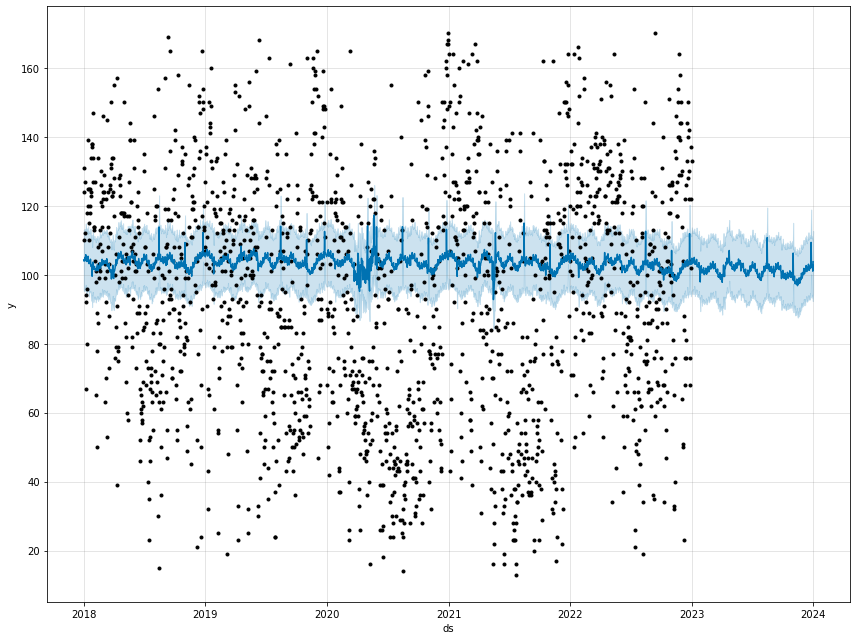

In [23]:
m.plot(forecast[['ds','yhat','yhat_lower','yhat_upper']],figsize=(12,9))

In [24]:
forecast

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints Day,All Saints Day_lower,All Saints Day_upper,...,windspeed_100m (km/h),windspeed_100m (km/h)_lower,windspeed_100m (km/h)_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,92.812895,170.0,95.377710,113.027060,92.812895,92.812895,0.0,0.0,0.0,...,-1.136093,-1.136093,-1.136093,1.983689,1.983689,1.983689,0.0,0.0,0.0,104.254461
1,2018-01-02,92.818546,170.0,95.409641,112.730015,92.818546,92.818546,0.0,0.0,0.0,...,-1.136093,-1.136093,-1.136093,2.010118,2.010118,2.010118,0.0,0.0,0.0,103.941765
2,2018-01-03,92.824198,170.0,95.361464,113.305774,92.824198,92.824198,0.0,0.0,0.0,...,-1.136093,-1.136093,-1.136093,2.027282,2.027282,2.027282,0.0,0.0,0.0,104.407938
3,2018-01-05,92.835501,170.0,96.507040,113.135924,92.835501,92.835501,0.0,0.0,0.0,...,-1.136093,-1.136093,-1.136093,2.030585,2.030585,2.030585,0.0,0.0,0.0,105.097505
4,2018-01-06,92.841152,170.0,95.346351,113.321973,92.841152,92.841152,0.0,0.0,0.0,...,-1.136093,-1.136093,-1.136093,2.015521,2.015521,2.015521,0.0,0.0,0.0,104.341324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2168,2023-12-27,90.886863,170.0,93.641943,110.560045,90.611679,91.175734,0.0,0.0,0.0,...,-1.136093,-1.136093,-1.136093,1.721086,1.721086,1.721086,0.0,0.0,0.0,102.164408
2169,2023-12-28,90.883441,170.0,93.388905,110.896673,90.607272,91.173227,0.0,0.0,0.0,...,-1.136093,-1.136093,-1.136093,1.778711,1.778711,1.778711,0.0,0.0,0.0,102.127556
2170,2023-12-29,90.880019,170.0,94.230476,111.205959,90.603649,91.170680,0.0,0.0,0.0,...,-1.136093,-1.136093,-1.136093,1.833355,1.833355,1.833355,0.0,0.0,0.0,102.944793
2171,2023-12-30,90.876596,170.0,92.389257,110.032601,90.600110,91.168382,0.0,0.0,0.0,...,-1.136093,-1.136093,-1.136093,1.883813,1.883813,1.883813,0.0,0.0,0.0,101.055010
